# BookWorm App

A small app that extracts entities and relations from a book into a graph and stores them in a json file.  
Several models were tested for this app, but in the end I settled for a distilled and quantized version of DeepSeek R1 (one that could fit on my RTX 4070 12GB).
The final implementation of the model can be found in [./book_worm.py](./book_worm.py)

It gives decent results ![book-grapg](./assets/book-graph.png)

## Problems
This project doesn't deduplicate entities, as can be seen in this [screenshot](./assets/two-poirots.png).  
And it sometimes makes up names, as can be seen in this [screenshot](./assets/made-up-names.png).

The model also shows issues returning actual JSON format. 

## Improvements

To increase the accuracy we could do a number of things:
- Finetune a model, similar to how REBEL and NER were trained
  - The current model barely fits on my local machine, so if we were to retrain this model, we'd have to find more resources
- Inject the graph into the prompt on each iteration
  - This may lead to an evergrowing prompt, possibly causing max number of tokens to be hit
- Finetine the prompt to make it more strict
- Use one-shot or two-shot inference
  - The first attempts resulted in the model returning the examples verbatim


In [1]:
! pip install -q -U -r ../requirements.txt

In [2]:
## Import bookworm
from book_worm import BookWorm
from graph_to_image import to_image

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [3]:
worm = BookWorm()

In [4]:
## Setup text splitter to break up books in chunks
from langchain_community.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import TokenTextSplitter

text_splitter = TokenTextSplitter(chunk_size=200, chunk_overlap=10)

In [5]:
import torch

BYTES_IN_GB = 1000_000_000

def print_mem():
    (free, total) = torch.cuda.mem_get_info()
    used = total - free
    
    perc_usaged = round(used / total * 100.0, 1)
    used_gb = round(used / BYTES_IN_GB, 1)
    total_gb = round(total / BYTES_IN_GB, 1)
    print(f'CUDA mem usage: {used_gb}/{total_gb}GB ({perc_usaged}%)')

print_mem()

CUDA mem usage: 9.8/12.5GB (78.5%)


In [6]:
test_data = {
    "nodes": {
        "Bruce Wayne": {
            "name": "Batman"
        },
        "The Joker": {
            "name": "The Joker"
        }
    },
    "edges": {
        "Bruce Wayne": {
            "The Joker": "Archenemies"
        }
    }
}

def to_graph(data):
    nodes = data["nodes"].keys()
    edges = [
        (source, target)
        for source, targets in data["edges"].items()
        for target in targets.keys()
    ]

    node_labels = {node_id: node["name"] for node_id, node in data["nodes"].items()}
    edge_labels = {
        (source, target): rel
        for source, targets in data["edges"].items()
        for target, rel in targets.items()
    }

    return (
        nodes,
        edges,
        node_labels,
        edge_labels
    )

test_graph = to_graph(test_data)

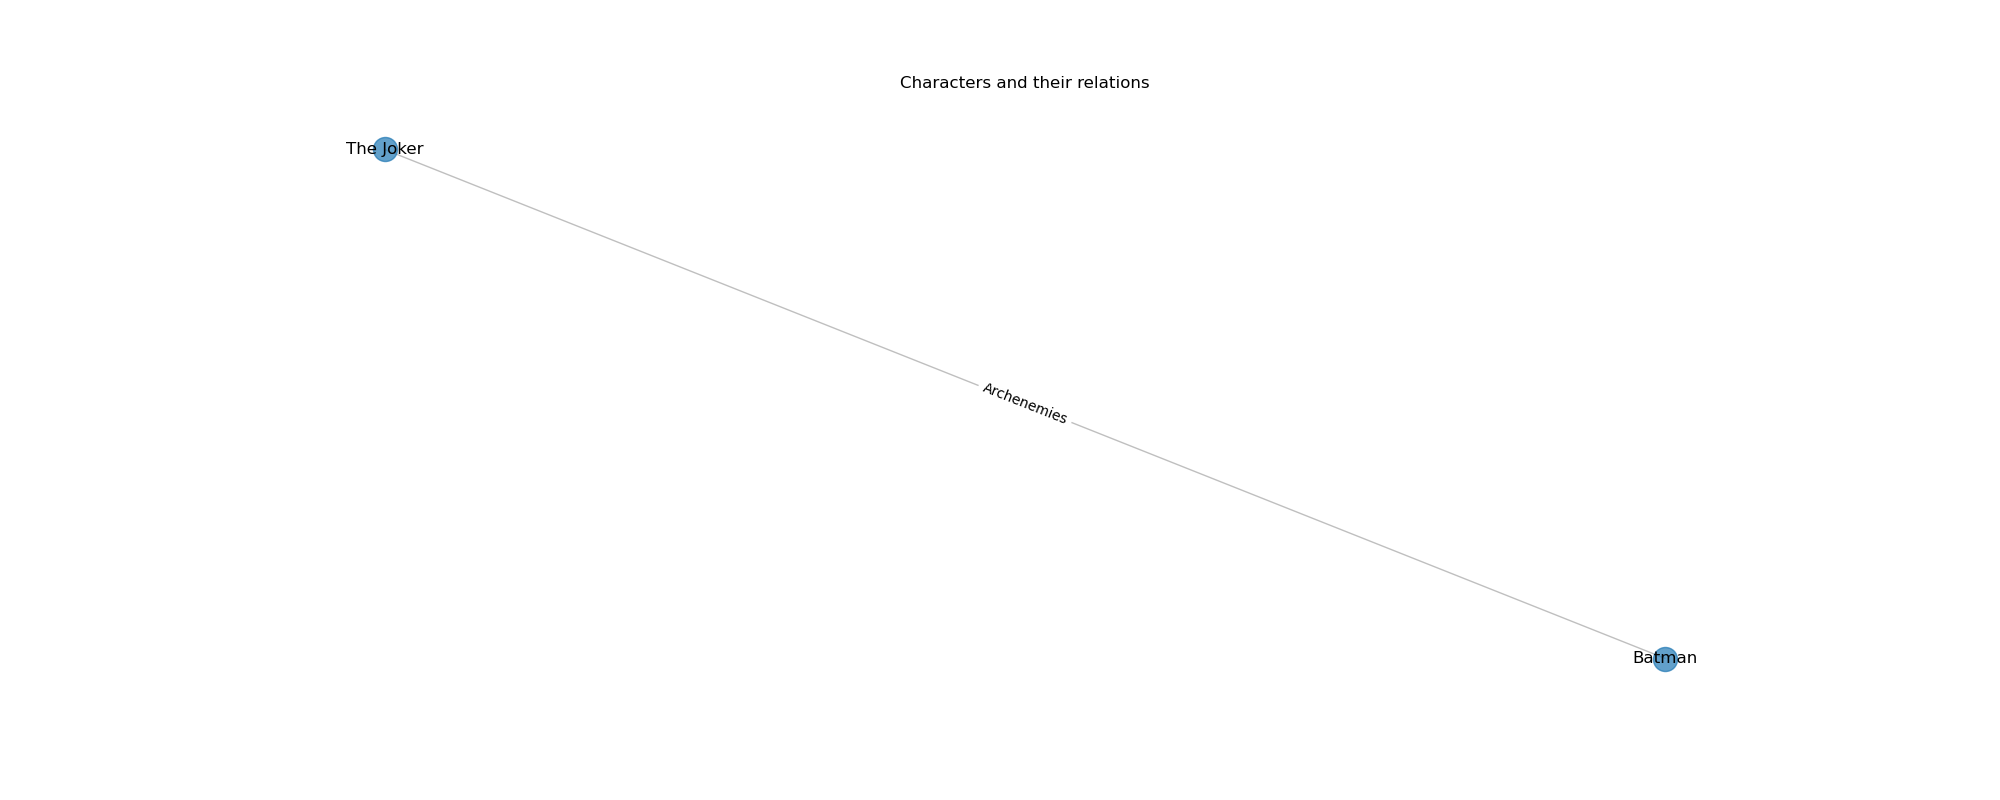

In [7]:
def visualize(data):
    graph_data = to_graph(data)
    img = to_image(*graph_data)
    
    return img

visualize(test_data)

In [8]:
import gradio as gr
import time
import json
import pathlib

def read_book(filepath):
    file_type = pathlib.Path(filepath).suffix

    loader = {
        ".pdf": PyPDFLoader,
        ".txt": TextLoader
    }[file_type](filepath)
    
    doc = loader.load()
    chunks = text_splitter.split_documents(doc)

    relationships = {}
    graph = visualize(worm.graph_data())
    
    for i, chunk in enumerate(chunks):
        yield [
            f"Reading page {i+1}/{len(chunks)}....",
            chunk.page_content,
            graph
        ]
        t0 = time.time()        
        relationships = worm.extract_relationships(chunk.page_content)
        t1 = time.time()
        
        if len(relationships) > 0:
            graph = visualize(worm.graph_data())

        yield [
            f"Read page {i+1}/{len(chunks)} in {t1 - t0}seconds.\n",
            f"Found {len(relationships)} new relationships.\n",
            graph
        ]
        time.sleep(2)

    with open("data/graph.json", "w") as f:
        json.dump(worm.graph_data(), f, indent=2)

with gr.Blocks(fill_height=True) as app:
    gr.Markdown("The coolest book reading club!")

    with gr.Row(equal_height=True):
        with gr.Column():
            upload = gr.File(label="Upload a book")

            btn = gr.Button(value="Read book")

            response = gr.Textbox(label="Action")
            
            chapter = gr.Textbox(label="Current chapter")
            
        with gr.Column():
                
            graph = gr.Image(type="pil")

        btn.click(
            fn=read_book,
            inputs=[upload],
            outputs=[response, chapter, graph]
        )

In [9]:
app.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [10]:
# with open("data/graph.json", "w") as f:
#     json.dump(worm.graph_data(), f, indent=2)

In [11]:
# app.close()